In [1]:
from cmath import log
import uproot as up
import awkward as ak
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema, TreeMakerSchema
from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)
from template.temp_class import ntuplize
import numpy as np
import argparse
import os
from utils import common_helper as com
from utils import analyze_helper as ana
from coffea import hist as chist
import yaml

In [2]:
import numba as nb

@nb.jit(nopython=True)
def set_elec_fr_weight(pt,eta):
    if 10<pt<=20:
        if 0<abs(eta)<=1:
            return 0.747
        elif 1<abs(eta)<=1.5:
            return 0.686
        elif 1.5<abs(eta)<=2.0:
            return 0.774
        elif 2.0<abs(eta):
            return 0.764
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 20<pt<=25:
        if 0<abs(eta)<=1:
            return 0.584
        elif 1<abs(eta)<=1.5:
            return 0.580
        elif 1.5<abs(eta)<=2.0:
            return 0.598
        elif 2.0<abs(eta):
            return 0.573
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 25<pt<=30:
        if 0<abs(eta)<=1:
            return 0.537
        elif 1<abs(eta)<=1.5:
            return 0.532
        elif 1.5<abs(eta)<=2.0:
            return 0.512
        elif 2.0<abs(eta):
            return 0.480
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 30<pt<=35:
        if 0<abs(eta)<=1:
            return 0.484
        elif 1<abs(eta)<=1.5:
            return 0.512
        elif 1.5<abs(eta)<=2.0:
            return 0.470
        elif 2.0<abs(eta):
            return 0.418
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>35:
        if 0<abs(eta)<=1:
            return 0.216
        elif 1<abs(eta)<=1.5:
            return 0.201
        elif 1.5<abs(eta)<=2.0:
            return 0.174
        elif 2.0<abs(eta):
            return 0.110
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1

@nb.jit(nopython=True)    
def set_mu_fr_weight(pt,eta):
    if 10<pt<=20:
        if 0<abs(eta)<=1:
            return 0.350
        elif 1<abs(eta)<=1.5:
            return 0.396
        elif 1.5<abs(eta)<=2.0:
            return 0.438
        elif 2.0<abs(eta):
            return 0.492
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 20<pt<=25:
        if 0<abs(eta)<=1:
            return 0.306
        elif 1<abs(eta)<=1.5:
            return 0.367
        elif 1.5<abs(eta)<=2.0:
            return 0.435
        elif 2.0<abs(eta):
            return 0.483
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 25<pt<=30:
        if 0<abs(eta)<=1:
            return 0.297
        elif 1<abs(eta)<=1.5:
            return 0.355
        elif 1.5<abs(eta)<=2.0:
            return 0.412
        elif 2.0<abs(eta):
            return 0.490
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif 30<pt<=35:
        if 0<abs(eta)<=1:
            return 0.289
        elif 1<abs(eta)<=1.5:
            return 0.358
        elif 1.5<abs(eta)<=2.0:
            return 0.421
        elif 2.0<abs(eta):
            return 0.511
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    elif pt>35:
        if 0<abs(eta)<=1:
            return 0.327
        elif 1<abs(eta)<=1.5:
            return 0.360
        elif 1.5<abs(eta)<=2.0:
            return 0.436
        elif 2.0<abs(eta):
            return 0.546
        else:
            print("Sth wrong with the muon eta cut!")
            return -1
    else:
        print("Sth wrong with the muon pt cut!")
        return -1

@nb.jit(nopython=True)
def non_prompt_weight(pt1_array,eta1_array,pt2_array,eta2_array,iselectron1_array,iselectron2_array,istight1_array,istight2_array):
    w_array = []
    for i in range(len(pt1_array)):
        pt1 = pt1_array[i]
        eta1 = eta1_array[i]
        pt2 = pt2_array[i]
        eta2 = eta2_array[i]
        iselectron1 = iselectron1_array[i]
        iselectron2 = iselectron2_array[i]
        istight1 = istight1_array[i]
        istight2 = istight2_array[i]
        if iselectron1 == True:
            w1 = set_elec_fr_weight(pt1,eta1)
        else:
            w1 = set_mu_fr_weight(pt1,eta1)
        if iselectron2 == True:
            w2 = set_elec_fr_weight(pt2,eta2)
        else:
            w2 = set_mu_fr_weight(pt2,eta2)
        w = (1-istight1)*w1/(1-w1) + (1-istight2)*w2/(1-w2) - (1-istight1)*(1-istight2)*w1/(1-w1)*w2/(1-w2)
        w_array.append(w)
    return w_array

@nb.jit(nopython=True)
def Data_set_elec_chargeflip_weight(pt,eta):
    if 20<=pt<=40:
        if 0<abs(eta)<=1:
            return 0.000463
        elif 1<abs(eta)<=1.5:
            return 0.000466
        elif 1.5<abs(eta)<=2.0:
            return 0.000934
        elif 2.0<abs(eta):
            return 0.001295
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 40<pt<=60:
        if 0<abs(eta)<=1:
            return 0.000187
        elif 1<abs(eta)<=1.5:
            return 0.000550
        elif 1.5<abs(eta)<=2.0:
            return 0.001159
        elif 2.0<abs(eta):
            return 0.001883
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 60<pt<=80:
        if 0<abs(eta)<=1:
            return 0.000195
        elif 1<abs(eta)<=1.5:
            return 0.000594
        elif 1.5<abs(eta)<=2.0:
            return 0.001548
        elif 2.0<abs(eta):
            return 0.002406
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>80:
        if 0<abs(eta)<=1:
            return 0.000250
        elif 1<abs(eta)<=1.5:
            return 0.001006
        elif 1.5<abs(eta)<=2.0:
            return 0.001807
        elif 2.0<abs(eta):
            return 0.003609
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1
    
@nb.jit(nopython=True)
def MC_set_elec_chargeflip_weight(pt,eta):
    if 20<=pt<=40:
        if 0<abs(eta)<=1:
            return 0.000177
        elif 1<abs(eta)<=1.5:
            return 0.000162
        elif 1.5<abs(eta)<=2.0:
            return 0.000266
        elif 2.0<abs(eta):
            return 0.000283
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 40<pt<=60:
        if 0<abs(eta)<=1:
            return 0.000087
        elif 1<abs(eta)<=1.5:
            return 0.000145
        elif 1.5<abs(eta)<=2.0:
            return 0.000283
        elif 2.0<abs(eta):
            return 0.000409
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif 60<pt<=80:
        if 0<abs(eta)<=1:
            return 0.000385
        elif 1<abs(eta)<=1.5:
            return 0.000468
        elif 1.5<abs(eta)<=2.0:
            return 0.000567
        elif 2.0<abs(eta):
            return 0.000779
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    elif pt>80:
        if 0<abs(eta)<=1:
            return 0.000772
        elif 1<abs(eta)<=1.5:
            return 0.000775
        elif 1.5<abs(eta)<=2.0:
            return 0.000904
        elif 2.0<abs(eta):
            return 0.001328
        else:
            print("Sth wrong with the electron eta cut!")
            return -1
    else:
        print("Sth wrong with the electron pt cut!")
        return -1

@nb.jit(nopython=True)
def charge_flip_weight(pt1_array,eta1_array,pt2_array,eta2_array,iselectron1_array,iselectron2_array,isdata):
    w_array = []
    if isdata==True:
        for i in range(len(pt1_array)):
            pt1 = pt1_array[i]
            eta1 = eta1_array[i]
            pt2 = pt2_array[i]
            eta2 = eta2_array[i]
            iselectron1 = iselectron1_array[i]
            iselectron2 = iselectron2_array[i]
            w1 = Data_set_elec_chargeflip_weight(pt1,eta1)
            w2 = Data_set_elec_chargeflip_weight(pt2,eta2)
            w = (1-iselectron1)*w1/(1-w1) + (1-iselectron2)*w2/(1-w2)
            w_array.append(w)
    else:
        for i in range(len(pt1_array)):
            pt1 = pt1_array[i]
            eta1 = eta1_array[i]
            pt2 = pt2_array[i]
            eta2 = eta2_array[i]
            iselectron1 = iselectron1_array[i]
            iselectron2 = iselectron2_array[i]
            w1 = MC_set_elec_chargeflip_weight(pt1,eta1)
            w2 = MC_set_elec_chargeflip_weight(pt2,eta2)
            w = (1-iselectron1)*w1/(1-w1) + (1-iselectron2)*w2/(1-w2)
            w_array.append(w)
    return w_array

def list_concatenate(list1,list2):
    new_list = []
    for a in list1:
        new_list.append(a)
    for b in list2:
        new_list.append(b)
    return new_list

Create type 1 hist_plot named "mll".
Create type 1 hist_plot named "mjj".
DoubleMuon_Run2018A
ssww_events_new/DoubleMuon_Run2018A/0.parquet 	1/85


ValueError: buffer is too short for NumpyArray: expected 131, buffer has 17 items (17 bytes)

(https://github.com/scikit-hep/awkward-1.0/blob/1.5.1/src/awkward/operations/convert.py#L4761)

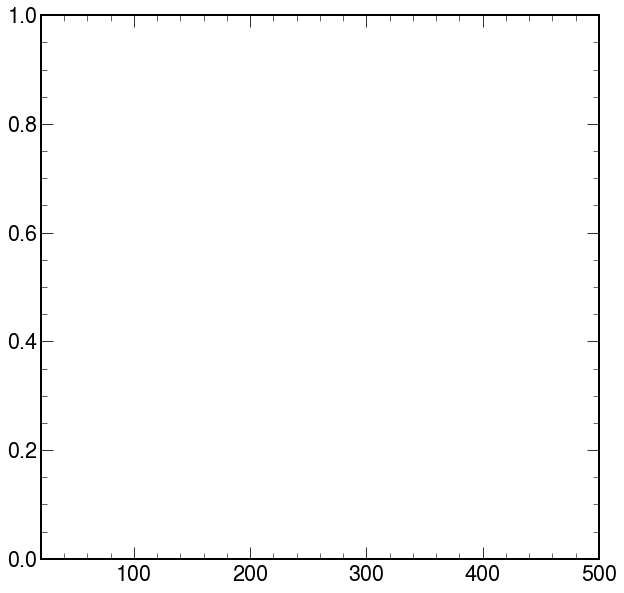

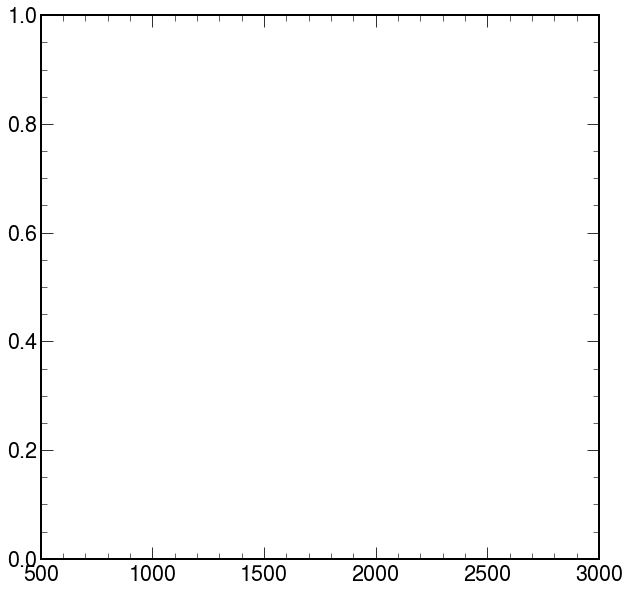

In [6]:
from yty_hist_class import yty_histplot

nanov7_dir = r'/data/pubfs/pku_visitor/public_write/download/datasets/nanov7'
with open(f"/data/pubfs/tyyang99/jupyter_files/changexs_datasets.yaml", 'r') as f:
    mc_yaml = yaml.load(f, Loader=yaml.FullLoader)
with open(f"/data/pubfs/tyyang99/jupyter_files/data_2018_nanov7.yaml", 'r') as f:
    data_yaml = yaml.load(f, Loader=yaml.FullLoader)
isdata = True
Lumi = 60.0*1e3
year='2018'

buffer_out_range_list = []

Data_merge = [
             'DoubleMuon_Run2018A','DoubleMuon_Run2018B','DoubleMuon_Run2018C','DoubleMuon_Run2018D',
             'EGamma_Run2018A','EGamma_Run2018B','EGamma_Run2018C','EGamma_Run2018D',
             'SingleMuon_Run2018A','SingleMuon_Run2018B','SingleMuon_Run2018C','SingleMuon_Run2018D',
             'MuonEG_Run2018A','MuonEG_Run2018B','MuonEG_Run2018C','MuonEG_Run2018D'
             ]

# Data_merge = [
#              'EGamma_Run2018D',
#              'SingleMuon_Run2018D',
# #              'MuonEG_Run2018A','MuonEG_Run2018B','MuonEG_Run2018C','MuonEG_Run2018D'
#              ]
    
WW_merge = ['WpWpJJ_EWK', 'WpWpJJ_QCD']
WZ_EWK = ['WLLJJ_EWK']
WZ_merge = ['WZTo3LNu_0Jets_MLL_4to50','WZTo3LNu_1Jets_MLL_4to50','WZTo3LNu_2Jets_MLL_4to50','WZTo3LNu_3Jets_MLL_4to50',
           'WZTo3LNu_0Jets_MLL_50','WZTo3LNu_1Jets_MLL_50','WZTo3LNu_2Jets_MLL_50','WZTo3LNu_3Jets_MLL_50']
ZZ_merge = ['ZZJJTo4L_EWK','ZZJJTo4L_QCD','ZZJJTo4L_int','ggZZ_2e2mu',
           'ggZZ_2e2tau','ggZZ_2mu2tau','ggZZ_4e','ggZZ_4mu','ggZZ_4tau','ggZZ_4tau_ext']
TVX_merge = ['TTGJets','TTZToQQ','TTZToQQ_ext','TTZToLLNuNu_M_10',
             'TTWJetsToQQ','TTWJetsToLNu','tZq']
VG_merge = ['Zgamma_EWK','Zgamma_EWK_ext','Wgamma_EWK','Wgamma_int']
WS_merge = ['WWTo2L2Nu',
            'ggWW_ee','ggWW_em','ggWW_et','ggWW_me','ggWW_mm','ggWW_mt','ggWW_te','ggWW_tm','ggWW_tt',
            'TTTo2L2Nu','ST_tW_top','ST_tW_antitop',
            'DYJetsToLL_M50','DYJets_M10to50','DYJets_M10to50_ext','ggh_ww','ggh_zz','ggh_tautau',
            'VBF_HToZZTo4L','VBFHToWWTo2L2Nu','VBFHToTauTau',
            'ttHToNonbb','VHToNonbb']
Other_merge = ['WW_DS','WWW','WWZ','WZZ','ZZZ','WWG']

PROCESSES = [WW_merge, WZ_EWK, WZ_merge, ZZ_merge, TVX_merge, VG_merge, WS_merge, Other_merge]
# PROCESSES = [WW_merge, WZ_EWK]
legendlist = ['$W^\pm W^\pm$', 'WZ_EWK', 'WZ', 'ZZ', 'TVX', '$V\gamma$','ws_sample', 'others']

# test_merge = [[i] for i in Data_merge]
# legendlist = [i+'_cut np and ws' for i in Data_merge]

test_merge = [Data_merge]
legendlist = ['data']

# test_merge = [WW_merge, WZ_EWK, WZ_merge, ZZ_merge, TVX_merge, VG_merge]
# legendlist = ['$W^\pm W^\pm$', 'WZ_EWK', 'WZ', 'ZZ', 'TVX', '$V\gamma$']

# test_merge = [WW_merge, WZ_EWK]
# legendlist = ['$W^\pm W^\pm$', 'WZ_EWK']

nonprompt_mll_array_list = []
nonprompt_mll_weight_list = []
nonprompt_mjj_array_list = []
nonprompt_mjj_weight_list = []

nonprompt_label_list = []
wrong_sign_label_list = []
processes_label_list = []

wrong_sign_mll_array_list = []
wrong_sign_mll_weight_list = []
wrong_sign_mjj_array_list = []
wrong_sign_mjj_weight_list = []

default_mll_histbins = [20., 80., 140., 240., 500]
default_mjj_histbins = [500., 650., 800., 1000., 1200., 1500., 1800., 2300., 3000.]

mll_hist = yty_histplot('mll',1,default_mll_histbins)
mjj_hist = yty_histplot('mjj',1,default_mjj_histbins)

for i,process_list in enumerate(test_merge):
# for i,process_list in enumerate(PROCESSES):
    legend = legendlist[i]
    
    temp_nonprompt_label_list = []
    temp_wrong_sign_label_list = []
    temp_processes_label_list = []
    
    for process in process_list:
        mll_array_list = []
        mll_weight_list = []
        mjj_array_list = []
        mjj_weight_list = []

        temp_nonprompt_mll_array_list = []
        temp_nonprompt_mll_weight_list = []
        temp_nonprompt_mjj_array_list = []
        temp_nonprompt_mjj_weight_list = []

        temp_wrong_sign_mll_array_list = []
        temp_wrong_sign_mll_weight_list = []
        temp_wrong_sign_mjj_array_list = []
        temp_wrong_sign_mjj_weight_list = []
        
        if process.endswith('_ext'):
            continue
        else:
            print(process)
            process_dir = 'ssww_events_new/'+process
            if isdata==True:
                pass
            else:
                xs = mc_yaml[process]['xs']
            nevents = 0
            parquet_list = []
            
            if process+'_ext' in process_list:
                process_ext_dir = 'ssww_events_new/'+process+'_ext'
                for parq_ext_file in os.listdir(process_ext_dir):
                    parquet_list.append(process_ext_dir+'/'+parq_ext_file)
            else:
                pass
            
            for parq_file in os.listdir(process_dir):
                parquet_list.append(process_dir+'/'+parq_file)
                
            for n_par, parquet_file in enumerate(parquet_list):
                parquet_dir = parquet_file
                print(parquet_dir,'\t%d/%d'%(n_par+1,len(parquet_list)))

                events = NanoEventsFactory.from_parquet(parquet_dir, schemaclass=NanoAODSchema).events()
                
                nevents += events.nevents[0]

                muons = events.Muon
                electrons = events.Electron
                taus = events.Tau
                good_jets = events.Jet
                MET = events.MET
                puppimet = events.PuppiMET
                
                loose_elec_barrel = (abs(electrons.eta + electrons.deltaEtaSC) < 1.479) & (abs(electrons.dz) < 0.1) & (abs(electrons.dxy) < 0.05)
                Combined_Isolation_Barrel = (electrons.dr03TkSumPt+(1*((electrons.dr03EcalRecHitSumEt-1)>0)*(electrons.dr03EcalRecHitSumEt-1)+0*((electrons.dr03EcalRecHitSumEt-1)<=0))+electrons.dr03HcalDepth1TowerSumEt)/electrons.pt
                loose_elec_endcap = (abs(electrons.eta + electrons.deltaEtaSC) > 1.479) & (abs(electrons.dz) < 0.2) & (abs(electrons.dxy) < 0.1) & (electrons.sieie < 0.03) & (electrons.eInvMinusPInv < 0.014)
                Combined_Isolation_Endcap = (electrons.dr03TkSumPt+electrons.dr03EcalRecHitSumEt+electrons.dr03HcalDepth1TowerSumEt)/electrons.pt
                
                Isolation_Barrel_sel = loose_elec_barrel & (Combined_Isolation_Barrel<0.0571)
                Isolation_Endcap_sel = loose_elec_endcap & (Combined_Isolation_Endcap<0.05880)
                combined_iso_sel = Isolation_Barrel_sel | Isolation_Endcap_sel
                
                loose_elec_sel_pdgmva = (loose_elec_barrel | loose_elec_endcap) & (electrons.pt > 10) & (abs(electrons.eta+electrons.deltaEtaSC) < 2.5) & (electrons.cutBased >= 3)
                loose_elec_sel_drmu = ana.is_clean(electrons,muons,0.4)
                loose_elec_sel_drmu = ak.Array(loose_elec_sel_drmu)
                loose_elec_sel = loose_elec_sel_pdgmva & loose_elec_sel_drmu
                
                mvaFall17V2Iso_WP90_sel = electrons.mvaFall17V2Iso_WP90
                
                tight_elec_sel = loose_elec_sel & mvaFall17V2Iso_WP90_sel & combined_iso_sel
                electrons['istight'] = tight_elec_sel

                events['nloose_muons'] = np.sum(muons.isloose==1,axis=1)
                events['ntight_muons'] = np.sum(muons.istight==1,axis=1)

                events['nloose_electrons'] = np.sum(electrons.isloose==1,axis=1)
                events['ntight_electrons'] = np.sum(electrons.istight==1,axis=1)

                events['ngood_jets'] = ak.count(good_jets.pt,axis=1)

#                 print('buffer outrange!')
#                 buffer_out_range_list.append(parquet_dir)
#                 continue

                good_tau_sel1 = (taus.pt > 20) & (abs(taus.eta) < 2.3) & ((taus.decayMode!=5) & (taus.decayMode!=6)) & (taus.idDeepTau2017v2p1VSjet>>2 & 1)
                good_tau_sel2 = (taus.idDeepTau2017v2p1VSe > 16) & (taus.idDeepTau2017v2p1VSjet > 16) & (taus.idDeepTau2017v2p1VSmu > 4)
                good_tau_sel3 = ana.is_clean(taus,muons,0.4) & ana.is_clean(taus,electrons,0.4)
                good_tau_sel = good_tau_sel1 & good_tau_sel2 & good_tau_sel3
                
                taus['isgood'] = good_tau_sel
                events['ngood_taus'] = np.sum(good_tau_sel,axis=1)
                
                #2lepton and multijets
                nleps_sel = events.nloose_muons+events.nloose_electrons==2
                nveto_leps_sel = events.nveto.muons+events.nveto.electrons==2
                njets_sel = events.ngood_jets>=2
                tau_veto_sel = events.ngood_taus==0
                _2lnj_sel = nleps_sel & nveto_leps_sel & njets_sel & tau_veto_sel

                #get selected objects
                sel_events = events[_2lnj_sel]
                sel_electrons = electrons[electrons.isloose==1][_2lnj_sel]
                sel_muons = muons[muons.isloose==1][_2lnj_sel]
                sel_leptons = ak.concatenate([sel_electrons,sel_muons],axis=1)
                sel_jets = good_jets[_2lnj_sel]

                #get 1e1mu, 2e, 2mu
                _2e_sel = (sel_events.nloose_electrons==2)
                _2m_sel = (sel_events.nloose_muons==2)
                _1e1mu_sel = (sel_events.nloose_electrons==1) & (sel_events.nloose_muons==1)

                #HLT for 1e1mu, 2e, 2mu
                HLT_all_list = ['Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                                'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL',
                                'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                                'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
                                'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
                                'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass3p8',
                                'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass8',
                                'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
                                'DiEle27_WPTightCaloOnly_L1DoubleEG',
                                'DoubleEle33_CaloIdL_MW',
                                'DoubleEle25_CaloIdL_MW',
                                'DoubleEle27_CaloIdL_MW',
                                'DoublePhoton70',
                                'IsoMu24','IsoMu27','IsoMu30','Mu50',
                                'Ele115_CaloIdVT_GsfTrkIdT',
                                'Ele27_WPTight_Gsf',
                                'Ele28_WPTight_Gsf',
                                'Ele32_WPTight_Gsf',
                                'Ele35_WPTight_Gsf',
                                'Ele38_WPTight_Gsf',
                                'Ele40_WPTight_Gsf',
                                'Ele32_WPTight_Gsf_L1DoubleEG',
                                'Photon200']
                if isdata==False:
                    HLT_list = ['Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                                'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL',
                                'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                                'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
                                'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
                                'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass3p8',
                                'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass8',
                                'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                                'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
                                'DiEle27_WPTightCaloOnly_L1DoubleEG',
                                'DoubleEle33_CaloIdL_MW',
                                'DoubleEle25_CaloIdL_MW',
                                'DoubleEle27_CaloIdL_MW',
                                'DoublePhoton70',
                                'IsoMu24','IsoMu27','IsoMu30','Mu50',
                                'Ele115_CaloIdVT_GsfTrkIdT',
                                'Ele27_WPTight_Gsf',
                                'Ele28_WPTight_Gsf',
                                'Ele32_WPTight_Gsf',
                                'Ele35_WPTight_Gsf',
                                'Ele38_WPTight_Gsf',
                                'Ele40_WPTight_Gsf',
                                'Ele32_WPTight_Gsf_L1DoubleEG',
                                'Photon200']
                else:
                    if 'MuonEG' in process:
                        HLT_list = ['Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                    'Mu12_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL',
                                    'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                                    'Mu23_TrkIsoVVL_Ele12_CaloIdL_TrackIdL_IsoVL',
                                    'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL_DZ',
                                    'Mu8_TrkIsoVVL_Ele23_CaloIdL_TrackIdL_IsoVL']
                    elif 'DoubleMuon' in process:
                        HLT_list = ['Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass3p8',
                                    'Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ_Mass8',
                                    'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass3p8',
                                    'Mu19_TrkIsoVVL_Mu9_TrkIsoVVL_DZ_Mass8']
                    elif 'EGamma' in process:
                        HLT_list = ['Ele23_Ele12_CaloIdL_TrackIdL_IsoVL_DZ',
                                    'Ele23_Ele12_CaloIdL_TrackIdL_IsoVL',
                                    'DiEle27_WPTightCaloOnly_L1DoubleEG',
                                    'DoubleEle33_CaloIdL_MW',
                                    'DoubleEle25_CaloIdL_MW',
                                    'DoubleEle27_CaloIdL_MW',
                                    'DoublePhoton70',
                                    'Ele115_CaloIdVT_GsfTrkIdT',
                                    'Ele27_WPTight_Gsf',
#                                     'Ele28_WPTight_Gsf',
                                    'Ele32_WPTight_Gsf',
                                    'Ele35_WPTight_Gsf',
                                    'Ele38_WPTight_Gsf',
                                    'Ele40_WPTight_Gsf',
                                    'Ele32_WPTight_Gsf_L1DoubleEG',
                                    'Photon200']
                                
                    elif 'SingleMuon' in process:
                        HLT_list = ['IsoMu24','IsoMu27','IsoMu30','Mu50']
                    else:
                        HLT_list = []
                
                HLT_sel1 = 0*ak.ones_like(sel_events.nloose_muons)==1
                HLT_sel2 = 0*ak.ones_like(sel_events.nloose_muons)==1
                for field in HLT_list:
                    if field in HLT_all_list:
                        HLT_sel1 = HLT_sel1 | sel_events.HLT[field]
                    else:
                        try:
                            HLT_sel2 = HLT_sel2 | sel_events.HLT[field]
                        except:
                            pass
                HLT_sel = HLT_sel1 & (1-HLT_sel2)

                #get leading and subleading lepton and mll
                leading_lep_idx = ak.argmax(sel_leptons.pt,axis=1,keepdims=True)
                subleading_lep_idx = 1-leading_lep_idx
                sel_leptons_mll = (sel_leptons[:,0]+sel_leptons[:,1]).mass

                #lepton selection
                lep_pt_sel = (sel_leptons[leading_lep_idx].pt>25) & (sel_leptons[subleading_lep_idx].pt>20)
                lep_mll_sel = sel_leptons_mll>20
                lep_mllzz_sel = (_2e_sel & (abs(sel_leptons_mll-91.2)>15)) | ((1-_2e_sel)==1)
                lep_tc_sel = np.sum(sel_leptons.istightcharge,axis=1)==2
                MET_pt_sel = MET[_2lnj_sel].pt>30

                #jets variables definition
                leading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==0]
                subleading_jet = sel_jets[ak.argsort(sel_jets.pt,axis=1,ascending=False)==1]
                jet1_pt = leading_jet.pt
                jet1_eta = leading_jet.eta
                jet2_pt = subleading_jet.pt
                jet2_eta = subleading_jet.eta
                zf_2leps = abs(sel_leptons.eta-(jet1_eta+jet2_eta)[:,0]/2)/abs(jet1_eta-jet2_eta)[:,0]
                sel_jets_mjj = (leading_jet+subleading_jet).mass

                #jets selection
                jet_btag_sel = np.sum(sel_jets.btagDeepFlavB>0.2783,axis=1)<1
                jet_mjj_sel = (sel_jets_mjj>500)
                jet_deta_sel = abs(jet1_eta-jet2_eta)>2.5
                jet_pt_sel = (jet1_pt>50) & (jet2_pt>50)
                zf_sel = (zf_2leps[:,0] < 0.75) & (zf_2leps[:,1] < 0.75)

                #same-sign
                ss_sel = (abs(np.sum(sel_electrons.charge,axis=1)+np.sum(sel_muons.charge,axis=1))>0)
                os_sel = (abs(np.sum(sel_electrons.charge,axis=1)+np.sum(sel_muons.charge,axis=1))==0)
                # ss_2lnj_sel = nleps_sel & njets_sel & ss_sel
                # os_2lnj_sel = nleps_sel & njets_sel & os_sel

                #merge_selection_condition
                lep_merged_sel = lep_pt_sel & lep_mll_sel & lep_mllzz_sel & lep_tc_sel
                jet_merged_sel = jet_btag_sel & jet_mjj_sel & jet_deta_sel & jet_pt_sel
                ss_all_merged_sel = lep_merged_sel & jet_merged_sel & MET_pt_sel & zf_sel & (HLT_sel==1) & ss_sel
                os_all_merged_sel = lep_merged_sel & jet_merged_sel & MET_pt_sel & zf_sel & (HLT_sel==1) & os_sel

                events_after_sel = sel_events[ss_all_merged_sel[:,0]]
                electrons_after_sel = sel_electrons[ss_all_merged_sel[:,0]]
                muons_after_sel = sel_muons[ss_all_merged_sel[:,0]]
                leptons_after_sel = sel_leptons[ss_all_merged_sel[:,0]]
                jets_after_sel = sel_jets[ss_all_merged_sel[:,0]]

                #tight leptons
                print(len(leptons_after_sel))
                tight_leps_sel = (ak.sum(leptons_after_sel.istight,axis=1)==2)
                tight_leptons = leptons_after_sel[tight_leps_sel]
                tight_leptons_jets = jets_after_sel[tight_leps_sel]

                os_tight_leps_sel = (ak.sum(sel_leptons[os_all_merged_sel[:,0]].istight,axis=1)==2)
                os_tight_leptons = sel_leptons[os_all_merged_sel[:,0]][os_tight_leps_sel]
                os_tight_leptons_jets = sel_jets[os_all_merged_sel[:,0]][os_tight_leps_sel]

                not_both_tight_leptons = leptons_after_sel[tight_leps_sel==0]
                not_both_tight_leptons_jets = jets_after_sel[tight_leps_sel==0]
                print(np.sum(tight_leps_sel))
                print(np.sum(os_tight_leps_sel))

                pt1 = not_both_tight_leptons.pt[:,0]
                eta1 = not_both_tight_leptons.eta[:,0]
                pt2 = not_both_tight_leptons.pt[:,1]
                eta2 = not_both_tight_leptons.eta[:,1]
                iselectron1 = not_both_tight_leptons.iselectron[:,0]
                iselectron2 = not_both_tight_leptons.iselectron[:,1]
                istight1 = not_both_tight_leptons.istight[:,0]
                istight2 = not_both_tight_leptons.istight[:,1]
                nonp_weight = non_prompt_weight(pt1, eta1, pt2, eta2, iselectron1, iselectron2, istight1, istight2)
                if isdata==False:
                    nonp_weight = ak.Array(nonp_weight)*events_after_sel.Generator.weight[tight_leps_sel==0]
                else:
                    nonp_weight = ak.Array(nonp_weight)

                cf_pt1 = os_tight_leptons.pt[:,0]
                cf_eta1 = os_tight_leptons.eta[:,0]
                cf_pt2 = os_tight_leptons.pt[:,1]
                cf_eta2 = os_tight_leptons.eta[:,1]
                cf_iselectron1 = os_tight_leptons.iselectron[:,0]
                cf_iselectron2 = os_tight_leptons.iselectron[:,1]
                cf_weight = charge_flip_weight(cf_pt1, cf_eta1, cf_pt2, cf_eta2, cf_iselectron1, cf_iselectron2, isdata)
                if isdata==False:
                    cf_weight = ak.Array(cf_weight)*sel_events.Generator.weight[os_all_merged_sel[:,0]][os_tight_leps_sel]
                else:
                    cf_weight = ak.Array(cf_weight)

                tight_leptons_mll = (tight_leptons[:,0]+tight_leptons[:,1]).mass
                non_prompt_mll = (not_both_tight_leptons[:,0]+not_both_tight_leptons[:,1]).mass
                wrong_sign_mll = (os_tight_leptons[:,0]+os_tight_leptons[:,1]).mass

                tight_leptons_mjj = (tight_leptons_jets[:,0]+tight_leptons_jets[:,1]).mass
                non_prompt_mjj = (not_both_tight_leptons_jets[:,0]+not_both_tight_leptons_jets[:,1]).mass
                wrong_sign_mjj = (os_tight_leptons_jets[:,0]+os_tight_leptons_jets[:,1]).mass

                temp_nonprompt_mll_array_list.append(non_prompt_mll)
                temp_nonprompt_mll_weight_list.append(nonp_weight)
                temp_nonprompt_mjj_array_list.append(non_prompt_mjj)
                temp_nonprompt_mjj_weight_list.append(nonp_weight)

                temp_wrong_sign_mll_array_list.append(wrong_sign_mll)
                temp_wrong_sign_mll_weight_list.append(cf_weight)
                temp_wrong_sign_mjj_array_list.append(wrong_sign_mjj)
                temp_wrong_sign_mjj_weight_list.append(cf_weight)

                mll_array_list.append(tight_leptons_mll)
                if isdata==False:
                    mll_weight_list.append(events_after_sel.Generator.weight[tight_leps_sel])
                mjj_array_list.append(tight_leptons_mjj)
                if isdata==False:
                    mjj_weight_list.append(events_after_sel.Generator.weight[tight_leps_sel])
            if isdata==True:
                mc_weight = 1
            else:
                mc_weight = Lumi*xs/nevents
            try:
                mll_hist.append_values(process,mll_array_list)
                if isdata==False:
                    mll_hist.append_weights(process,np.array(mll_weight_list)*mc_weight)
                mjj_hist.append_values(process,mjj_array_list)
                if isdata==False:
                    mjj_hist.append_weights(process,np.array(mjj_weight_list)*mc_weight)

                mll_hist.append_values(process+'_nonprompt',temp_nonprompt_mll_array_list)
                mll_hist.append_weights(process+'_nonprompt',[ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight])
                mjj_hist.append_values(process+'_nonprompt',temp_nonprompt_mjj_array_list)
                mjj_hist.append_weights(process+'_nonprompt',[ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight])

                mll_hist.append_values(process+'_wrongsign',temp_wrong_sign_mll_array_list)
                mll_hist.append_weights(process+'_wrongsign',[ak.concatenate(temp_wrong_sign_mll_weight_list)*mc_weight])
                mjj_hist.append_values(process+'_wrongsign',temp_wrong_sign_mjj_array_list)
                mjj_hist.append_weights(process+'_wrongsign',[ak.concatenate(temp_wrong_sign_mjj_weight_list)*mc_weight])
                
#                 nonprompt_mll_array_list.append(ak.concatenate(temp_nonprompt_mll_array_list))
#                 nonprompt_mll_weight_list.append(ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight)
#                 nonprompt_mjj_array_list.append(ak.concatenate(temp_nonprompt_mjj_array_list))
#                 nonprompt_mjj_weight_list.append(ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight)

#                 wrong_sign_mll_array_list.append(ak.concatenate(temp_wrong_sign_mll_array_list))
#                 wrong_sign_mll_weight_list.append(ak.concatenate(temp_wrong_sign_mll_weight_list)*mc_weight)
#                 wrong_sign_mjj_array_list.append(ak.concatenate(temp_wrong_sign_mjj_array_list))
#                 wrong_sign_mjj_weight_list.append(ak.concatenate(temp_wrong_sign_mjj_weight_list)*mc_weight)
                
                temp_nonprompt_label_list.append(process+'_nonprompt')
                temp_wrong_sign_label_list.append(process+'_wrongsign')
                temp_processes_label_list.append(process)
                
                nonprompt_label_list.append(process+'_nonprompt')
                wrong_sign_label_list.append(process+'_wrongsign')
            except:
                print(process+' error')
                continue
            if isdata==False:
                store_folder = "MC_new"
            else:
                store_folder = "Data_elecID"
            ak.to_parquet(ak.concatenate(mll_array_list),f"parquet_after_selection/{store_folder}/mll_{process}.parquet")
            if isdata==False:
                ak.to_parquet(ak.concatenate(mll_weight_list)*mc_weight,f"parquet_after_selection/{store_folder}/mll_weight_{process}.parquet")
            ak.to_parquet(ak.concatenate(temp_nonprompt_mll_array_list),f"parquet_after_selection/{store_folder}/mll_{process}_nonprompt.parquet")
            ak.to_parquet(ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight,f"parquet_after_selection/{store_folder}/mll_weight_{process}_nonprompt.parquet")
            ak.to_parquet(ak.concatenate(temp_wrong_sign_mll_array_list),f"parquet_after_selection/{store_folder}/mll_{process}_wrong_sign.parquet")
            ak.to_parquet(ak.concatenate(temp_wrong_sign_mll_weight_list)*mc_weight,f"parquet_after_selection/{store_folder}/mll_weight_{process}_wrong_sign.parquet")
            ak.to_parquet(ak.concatenate(mjj_array_list),f"parquet_after_selection/{store_folder}/mjj_{process}.parquet")
            if isdata==False:
                ak.to_parquet(ak.concatenate(mjj_weight_list)*mc_weight,f"parquet_after_selection/{store_folder}/mjj_weight_{process}.parquet")
            ak.to_parquet(ak.concatenate(temp_nonprompt_mjj_array_list),f"parquet_after_selection/{store_folder}/mjj_{process}_nonprompt.parquet")
            ak.to_parquet(ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight,f"parquet_after_selection/{store_folder}/mjj_weight_{process}_nonprompt.parquet")
            ak.to_parquet(ak.concatenate(temp_wrong_sign_mjj_array_list),f"parquet_after_selection/{store_folder}/mjj_{process}_wrong_sign.parquet")
            ak.to_parquet(ak.concatenate(temp_wrong_sign_mjj_weight_list)*mc_weight,f"parquet_after_selection/{store_folder}/mjj_weight_{process}_wrong_sign.parquet")
                
    mll_hist.merge(temp_processes_label_list,list_concatenate(temp_nonprompt_label_list,temp_wrong_sign_label_list),legend)
    mjj_hist.merge(temp_processes_label_list,list_concatenate(temp_nonprompt_label_list,temp_wrong_sign_label_list),legend)
    if not legend=='ws_sample':
        processes_label_list.append(legend)
#         processes_label_list.append(legend+'_wrongsign')

mll_hist.merge(nonprompt_label_list,[],'non_prompt')
mjj_hist.merge(nonprompt_label_list,[],'non_prompt')

mll_hist.merge(wrong_sign_label_list,[],'wrong_sign')
mjj_hist.merge(wrong_sign_label_list,[],'wrong_sign')

# processes_label_list.append('non_prompt')
processes_label_list.append('wrong_sign')

mll_hist.set_legend(legendbool=True)
mll_hist.draw(processes_label_list[:],stack=True)
mjj_hist.set_legend(legendbool=True)
mjj_hist.draw(processes_label_list[:],stack=True)

# mll_hist.save('data_mll.png')
# mjj_hist.save('data_mjj.png')

In [ ]:
buffer_out_range_list 

In [ ]:
processes_label_list

In [ ]:
# processes_test_list = ['$W^\\pm W^\\pm$','WZ_EWK','WZ','TVX','$V\\gamma$']
# mjj_hist.draw(processes_test_list[:])

In [ ]:
events.fields

In [ ]:
list_concatenate(['a','b'],['c','d'])

In [ ]:
HLT_sel

In [ ]:
ss_all_merged_sel

In [ ]:
processes_label_list

In [ ]:
list_concatenate(temp_nonprompt_label_list,temp_wrong_sign_label_list)

In [ ]:
temp_processes_label_list

In [ ]:
test_labels = []
for label in mjj_hist.values_dict.keys():
    if '_wrongsign' in label:
        if label.replace('_wrongsign','') in WS_merge:
#             if label.replace('_wrongsign','') not in ['DYJetsToLL_M50','DYJets_M10to50']:
            test_labels.append(label)
mjj_hist.draw(test_labels,clear=True,stack=True)
# mjj_hist.draw(['DYJetsToLL_M50_wrongsign','DYJets_M10to50_wrongsign'],clear=True,stack=True)

In [ ]:
ak.concatenate([[0,0,0],ak.Array([0,0,0]),np.array([0,0,0])])

In [ ]:
sel_events

In [ ]:
events.nevents[0]

In [ ]:
sel_events.HLT.fields

In [ ]:
np.sum(events.nveto.muons+events.nveto.electrons!=2)

In [ ]:
print(len(os.listdir(nanov7_dir+'/MuonEG/Run2018D-02Apr2020-v1/NANOAOD')))

In [ ]:
#             ak.to_parquet(ak.concatenate(mll_array_list),f"parquet_after_selection/mll_{process}.parquet")
#             ak.to_parquet(ak.concatenate(mll_weight_list),f"parquet_after_selection/mll_weight_{process}.parquet")
#             ak.to_parquet(ak.concatenate(temp_nonprompt_mll_array_list),f"parquet_after_selection/mll_{process}_nonprompt.parquet")
#             ak.to_parquet(ak.concatenate(temp_nonprompt_mll_weight_list)*mc_weight,f"parquet_after_selection/mll_weight_{process}_nonprompt.parquet")
#             ak.to_parquet(ak.concatenate(temp_wrong_sign_mll_array_list),f"parquet_after_selection/mll_{process}_wrong_sign.parquet")
#             ak.to_parquet(ak.concatenate(temp_wrong_sign_mll_weight_list)*mc_weight,f"parquet_after_selection/mll_weight_{process}_wrong_sign.parquet")
#             ak.to_parquet(ak.concatenate(mjj_array_list),f"parquet_after_selection/mjj_{process}.parquet")
#             ak.to_parquet(ak.concatenate(mjj_weight_list),f"parquet_after_selection/mjj_weight_{process}.parquet")
#             ak.to_parquet(ak.concatenate(temp_nonprompt_mjj_array_list),f"parquet_after_selection/mjj_{process}_nonprompt.parquet")
#             ak.to_parquet(ak.concatenate(temp_nonprompt_mjj_weight_list)*mc_weight,f"parquet_after_selection/mjj_weight_{process}_nonprompt.parquet")
#             ak.to_parquet(ak.concatenate(temp_wrong_sign_mjj_array_list),f"parquet_after_selection/mjj_{process}_wrong_sign.parquet")
#             ak.to_parquet(ak.concatenate(temp_wrong_sign_mjj_weight_list)*mc_weight,f"parquet_after_selection/mjj_weight_{process}_wrong_sign.parquet")

In [ ]:
loose_elec_sel & electrons.mvaFall17V2Iso_WP90 & combined_iso_sel

In [ ]:
electrons.mvaFall17V2Iso_WP90

In [ ]:
np.sum(combined_iso_sel)

In [ ]:
electrons.fields

In [5]:
combined_iso_sel & combined_iso_sel & combined_iso_sel
electrons['istight']=combined_iso_sel

In [13]:
loose_elec_sel[np.sum(electrons.isloose==1,axis=1)>0]

<Array [[True], [True], ... [True], [True]] type='128 * var * bool'>

In [22]:
mva = 1*ak.Array(mvaFall17V2Iso_WP90_sel)

ValueError: buffer is too short for NumpyArray: expected 131, buffer has 17 items (17 bytes)

(https://github.com/scikit-hep/awkward-1.0/blob/1.5.1/src/awkward/operations/convert.py#L4761)

In [21]:
np.sum(mva,axis=1)

ValueError: buffer is too short for NumpyArray: expected 131, buffer has 17 items (17 bytes)

(https://github.com/scikit-hep/awkward-1.0/blob/1.5.1/src/awkward/operations/convert.py#L4761)

ValueError: buffer is too short for NumpyArray: expected 131, buffer has 17 items (17 bytes)

(https://github.com/scikit-hep/awkward-1.0/blob/1.5.1/src/awkward/operations/convert.py#L4761)